# Covid-19
<hr/>
Pete Arnold<br/>19.4.2020 - 8.6.2020
<hr/>


This is a small project to examine some of the data available for cases and deaths for Covid-19 across various countries. You can run the code in the code boxes using the run button in the menu bar above. The currently running section will be indicated by \[*\] at the top left of the section (a number indicates the point in the sequence that the section was last run).

You can edit the code in the code sections and re-run them if you wish to experiment. The sections are expected to run in the order presented: if you get an error message trying running from the top.

The data from both sources needs to be made compatible, joined and cleaned a little before the analyses.

## Libraries and Functions

The majority of the work utilises the Tidyverse libraries including lubridate for data preparation and readxl for accessing the Excel data files. We make particular use of `%>%`, the pipe which allows us to list functions one after the other each operating on the results of the previous function. This makes it easier to read the sequence of functionality than when the functions are nested (e.g. `dataset %>% filter(rows) %>% select(columns)` rather than `select(filter(dataset, rows), columns)`).


In [12]:
library(tidyverse)
library(lubridate)
library(readxl)
library(openxlsx)

Some of the more obvious functionality has been moved to a separate file (covid-19_functions.R) where it may eventually form the basis for a useful library for re-use on other projects. The functions now available can be listed using `lsf.str()`.

In [13]:
source('covid-19_functions.R')
lsf.str()

archive_data : function (data, filename)  
clean_data : function (name)  
clean_url_data : function (name, date_origin)  
cumulative_cases : function (name)  
cumulative_deaths : function (name)  
fetch_data : function (url)  
fetch_data_sheet : function (url, sheet)  
get_first_case : function (name)  
get_first_case_at_pc : function (name, pc)  
get_first_smoothed_case_at_pc : function (name, pc)  
get_max_cases_deaths : function (name)  
get_max_cumulative_cases : function (name)  
get_max_smoothed_cases_deaths : function (name)  
load_data : function (filename)  
load_data_xlsx : function (filename, sheet)  
remove_known_problems : function (name)  
smooth_cases : function (name)  
smooth_deaths : function (name)  
update_data : function (url, filename)  
update_data_wales : function (url, filename)  

## Data Sources

The data for the world-wide incidence is taken from the European Centre for Disease Surveillance. The Welsh data is from Public Health Wales.

https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

http://www2.nphs.wales.nhs.uk:8080/CommunitySurveillanceDocs.nsf/Public/77FDB9A33544AEE88025855100300CAB/$file/Rapid%20COVID-19%20surveillance%20data.xlsx

### Update data from source(s) and reload

We can archive the latest dataset and then load the most recent files from the sources (Europe and Wales).

*** Please not that this code does not archive and update at present in order to be compatible with running in a binder (read-only). If you wish to archive use the commented out code. ***

In [14]:
## Load the supplied data file.
# load_data('covid-19.csv')

# URLs for the data sources
phw <- 'http://www2.nphs.wales.nhs.uk:8080/CommunitySurveillanceDocs.nsf/Public/77FDB9A33544AEE88025855100300CAB/$file/Rapid%20COVID-19%20surveillance%20data.xlsx?OpenElement'
ecdc <- 'http://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx'

## Fetch data only:
## From Europe.
# fetch_data(ecdc)
## And from Public Health Wales.
# fetch_data(phw)

## Archive, fetch and save data:
## From Europe.
# update_data(ecdc, 'covid-19.csv')
## And from Public Health Wales.
# update_data_wales(phw, 'covid-19-wales.csv')

## Data Preparation

Get the data into a consistent format. Here we start with the European data and re-organise the Welsh data to match. The data will form a list of daily cases and deaths from January to the present date. We then create cumulative sums and 7-day moving average columns. We also then gather single descriptive data for each country such as total population.

Second binder lesson: the binder seems unable to connect to the internet.

### Extract the Welsh data and reformat it to match the ECDC data

Get the Welsh cases data then the death data.

In [15]:
# Read the cases data from the Excel file and make the column names compatible
# with R replacing incompatible characters (e.g. a space) with '.'.
cases_wales <- load_data_xlsx('covid-19-wales.xlsx', sheet='Tests by specimen date') %>%
    rename_all(list(~make.names(.)))
# origin <- '1899-12-30'
# cases_wales <- fetch_data_sheet(phw, sheet='Tests by specimen date') %>%
#     rename_all(list(~make.names(.)))

## Modify the data frame to match the format that we'll get from the ECDC.
#cases_wales_modified <- cases_wales %>%
#    transmute(dateRep=Specimen.date, day=day(dateRep), month=month(dateRep), 
#              year=year(dateRep), cases=Cases..new., deaths=NA, 
#              countriesAndTerritories=Local.Authority, geold=NA,
#              countryterritoryCode=NA, popData2018=NA, continentExp=NA,
#              cum_cases=Cumulative.cases)

# And now get the deaths data and create the equivalent additional columns
# ordered by date (dateRep).
deaths_wales <- load_data_xlsx('covid-19-wales.xlsx', sheet='Deaths by date') %>%
    rename_all(list(~make.names(.)))
# deaths_wales <- fetch_data_sheet(phw, sheet='Deaths by date') %>%
#     rename_all(list(~make.names(.)))

deaths_wales_modified <- deaths_wales %>%
    transmute(dateRep=as.Date(Date.of.death, origin=origin),
              deaths=Daily.deaths, cum_deaths=Cumulative.deaths)

# Create a data frame with welsh cases and deaths.
cases_deaths_wales <- cases_wales %>%
    # Don't need Local Authority.
    select(-Local.Authority) %>%
    # Group the specimen data together, sum for each specimen date, and keep
    # only the first one (and remember to ungroup once done).
    group_by(Specimen.date) %>%
    mutate(Cases..new.=sum(Cases..new.), Cumulative.cases=sum(Cumulative.cases)) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    # Reformat to match ECDC data.
    transmute(dateRep=as.Date(Specimen.date, origin=origin), day=day(dateRep), month=month(dateRep), 
              year=year(dateRep), cases=Cases..new., 
              countriesAndTerritories='Wales', geoId=NA,
              countryterritoryCode=NA, popData2018=3187203, continentExp='Europe',
              cum_cases=Cumulative.cases) %>%
    # Include the deaths.
    merge(deaths_wales_modified, by='dateRep', all=TRUE) %>% distinct() %>%
    # Now that we have all the rows in the final data frame, we can adjust the
    # NAs to zero.
    mutate(deaths=ifelse(is.na(deaths), 0, deaths)) %>%
    mutate(cum_deaths=ifelse(is.na(cum_deaths), 0, cum_deaths)) %>%
    # And re-arrange the columns.
    transmute(dateRep, day, month, year, cases, deaths, countriesAndTerritories,
           geoId, countryterritoryCode, popData2018, continentExp,
           cum_cases, cum_deaths)

# Show the top few rows of the data (arranged so that the most recent data is topmost):
cat('Welsh Data\n', '----------\n', sep='')
cat('Number of Welsh rows: ', count(cases_deaths_wales)[[1]], sep='')
head(cases_deaths_wales %>% arrange(desc(dateRep)), 10)

Welsh Data
----------
Number of Welsh rows: 116

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,cum_cases,cum_deaths
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>
1,2020-06-06,6,6,2020,1,0,Wales,NA,NA,3187203,Europe,14396,1398
2,2020-06-05,5,6,2020,2,3,Wales,NA,NA,3187203,Europe,14395,1398
3,2020-06-04,4,6,2020,18,9,Wales,NA,NA,3187203,Europe,14393,1395
4,2020-06-03,3,6,2020,48,7,Wales,NA,NA,3187203,Europe,14375,1386
5,2020-06-02,2,6,2020,57,5,Wales,NA,NA,3187203,Europe,14327,1379
6,2020-06-01,1,6,2020,62,9,Wales,NA,NA,3187203,Europe,14270,1374
7,2020-05-31,31,5,2020,38,7,Wales,NA,NA,3187203,Europe,14208,1365
8,2020-05-30,30,5,2020,54,9,Wales,NA,NA,3187203,Europe,14170,1358
9,2020-05-29,29,5,2020,90,10,Wales,NA,NA,3187203,Europe,14116,1349


### Extract the ECDC data, clean it and fix known problems

Untidnesses and problems in the data which have become apparent through manual examination of the datasets on prior occasions are fixed by these functions.

In [16]:
cases_deaths_ecdc <-
    load_data('covid-19.csv') %>%
    clean_data() %>%
    remove_known_problems()

# Code for fetch fresh data (not working on binder).
# cases_deaths_ecdc <-
#     fetch_data(ecdc) %>%
#     clean_url_data(origin) %>%
#    remove_known_problems()

# Calculate the cumulative cases and deaths.
cases_deaths_ecdc <- cumulative_cases(cases_deaths_ecdc) 
cases_deaths_ecdc <- cumulative_deaths(cases_deaths_ecdc)

# Show the top few rows of the data:
cat('ECDC Data\n', '---------\n', sep='')
cat('Number of ECDC rows: ', count(cases_deaths_ecdc)[[1]], sep='')
head(cases_deaths_ecdc %>% arrange(desc(dateRep)), 10)

Parsed with column specification:
cols(
  dateRep = col_datetime(format = ""),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  cases = col_double(),
  deaths = col_double(),
  countriesAndTerritories = col_character(),
  geoId = col_character(),
  countryterritoryCode = col_character(),
  popData2018 = col_double(),
  continentExp = col_character()
)

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone '%d/%m/%Y'"


ECDC Data
---------
Number of ECDC rows: 21965

dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,cum_cases,cum_deaths
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2020-06-07,7,6,2020,582,18,Afghanistan,AF,AFG,37172386,Asia,19551,327
2020-06-07,7,6,2020,0,0,Angola,AO,AGO,30809762,Africa,84,4
2020-06-07,7,6,2020,0,0,Anguilla,AI,NA,NA,America,1,0
2020-06-07,7,6,2020,20,1,Albania,AL,ALB,2866376,Europe,1230,34
2020-06-07,7,6,2020,115,8,Algeria,DZ,DZA,42228429,Africa,10050,698
2020-06-07,7,6,2020,0,0,Andorra,AD,AND,77006,Europe,851,51
2020-06-07,7,6,2020,0,0,Antigua_and_Barbuda,AG,ATG,96286,America,25,3
2020-06-07,7,6,2020,983,16,Argentina,AR,ARG,44494502,America,22006,648
2020-06-07,7,6,2020,547,7,Armenia,AM,ARM,2951776,Europe,12364,190


### Combine the Welsh and ECDC data

In [17]:
# Now incorporate the Welsh national data.
cases_deaths <- cases_deaths_ecdc %>%
    rbind(cases_deaths_wales)

cat('Combined number of rows: ', count(cases_deaths)[[1]], sep='')

Combined number of rows: 22081

### Create smoothed data

Create the 7-day moving average for the cases and deaths.

In [18]:
cases_deaths <- cases_deaths %>%
    smooth_cases() %>%
    smooth_deaths()

# Show the top few rows of the data:
cat('Number of data rows: ', count(cases_deaths)[[1]], sep='')
head(cases_deaths, 10)

Number of data rows: 22081

dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,cum_cases,cum_deaths,smoothed_cases,smoothed_deaths
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2019-12-31,31,12,2019,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,NA,NA
2020-01-01,1,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,NA,NA
2020-01-02,2,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0
2020-01-03,3,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0
2020-01-04,4,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0
2020-01-05,5,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0
2020-01-06,6,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0
2020-01-07,7,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0
2020-01-08,8,1,2020,0,0,Afghanistan,AF,AFG,37172386,Asia,0,0,0,0


### Gather descriptive data for each country

The calulations will need access to typical data for each country, for example the total population, the maximum number of daily cases etc.

In [19]:
# Get (and report) the number of countries in the data frame.
no_countries <- (cases_deaths %>%
    select(countriesAndTerritories) %>% distinct %>% count())[[1]]
cat('Country count = ', no_countries, '\n', sep='')

# We'll be plotting curves scaled for easy comparison, so extract the maximum
# daily number of cases and deaths for each country.
countries_cases_deaths <- cases_deaths %>%
    get_max_cases_deaths()
# Likewise the smoothed data.
countries_smoothed_cases_deaths <- cases_deaths %>%
    get_max_smoothed_cases_deaths()
# And the cumulative cases.
countries_cum_cases <- cases_deaths %>%
    get_max_cumulative_cases()
# Extract the date to be used to as the starting point for the analysis. Define
# a percentage of the maximum smoothed daily cases.
trigger_pc <- 15
countries_first_case <- cases_deaths %>%
    left_join(countries_cases_deaths, by='countriesAndTerritories') %>% 
    left_join(countries_smoothed_cases_deaths, by='countriesAndTerritories') %>%
    get_first_smoothed_case_at_pc(trigger_pc)
# Alternative using a previous function.
# countries_first_case <- cases_deaths %>%
#    get_first_case()

# Merge the country data and check that we haven't generated any duplicates
# through a faulty merge.
countries <- countries_cases_deaths %>%
    full_join(countries_first_case, by='countriesAndTerritories') %>%
    full_join(countries_cum_cases, by='countriesAndTerritories') %>%
    full_join(countries_smoothed_cases_deaths, by='countriesAndTerritories')

cat('Check merged country data size = ', count(countries)[[1]], '\n', sep='')
# Show the top few rows of the data:
cat('Number of data rows: ', count(countries)[[1]], sep='')
head(countries, 10)
# List all of the countries (for reference later where we may wish to make a selection).
country_list <- sort(countries$countriesAndTerritories)
for (i in seq(1, length(country_list)[[1]], 4)){
    cat(country_list[i], country_list[i+1], country_list[i+2], country_list[i+3], '\n', sep=', ')
}

Country count = 211
Check merged country data size = 211
Number of data rows: 211

countriesAndTerritories,max_cases,max_deaths,firstCase,max_cum_cases,max_smoothed_cases,max_smoothed_deaths
<chr>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
Afghanistan,1063,32,2020-04-28,19551,760.2,12.4
Angola,9,2,2020-03-28,84,3.8,0.4
Anguilla,2,0,2020-03-29,1,0.4,0.0
Albania,34,3,2020-03-11,1230,25.6,1.8
Algeria,205,42,2020-03-22,10050,193.8,26.0
Andorra,79,4,2020-03-17,851,36.4,2.2
Antigua_and_Barbuda,6,2,2020-03-23,25,1.6,0.4
Argentina,1769,44,2020-04-24,22006,921.0,18.6
Armenia,697,19,2020-05-02,12364,574.4,10.4


Afghanistan, Angola, Anguilla, Albania, 
Algeria, Andorra, Antigua_and_Barbuda, Argentina, 
Armenia, Aruba, Australia, Austria, 
Azerbaijan, Bangladesh, Bahamas, Bahrain, 
Barbados, Belarus, Belgium, Belize, 
Benin, Bermuda, Bhutan, Bolivia, 
Bonaire, Saint Eustatius and Saba, Bosnia_and_Herzegovina, Botswana, Brazil, 
British_Virgin_Islands, Brunei_Darussalam, Bulgaria, Burkina_Faso, 
Burundi, Cambodia, Cameroon, Canada, 
Cape_Verde, Cases_on_an_international_conveyance_Japan, Cayman_Islands, Central_African_Republic, 
Congo, Colombia, Comoros, Costa_Rica, 
Cote_dIvoire, Croatia, Cuba, CuraÃ§ao, 
Cyprus, Czechia, Chad, Chile, 
China, Democratic_Republic_of_the_Congo, Denmark, Djibouti, 
Dominica, Dominican_Republic, Ecuador, Egypt, 
El_Salvador, Equatorial_Guinea, Eritrea, Estonia, 
Eswatini, Ethiopia, Falkland_Islands_(Malvinas), Faroe_Islands, 
Fiji, Finland, France, French_Polynesia, 
Gabon, Gambia, Georgia, Germany, 
Ghana, Gibraltar, Greece, Greenland, 
Grenada, Guam, Guatemala, 

## Examine the Data

### Plot the unsmoothed cases and death data for a selection of countries.

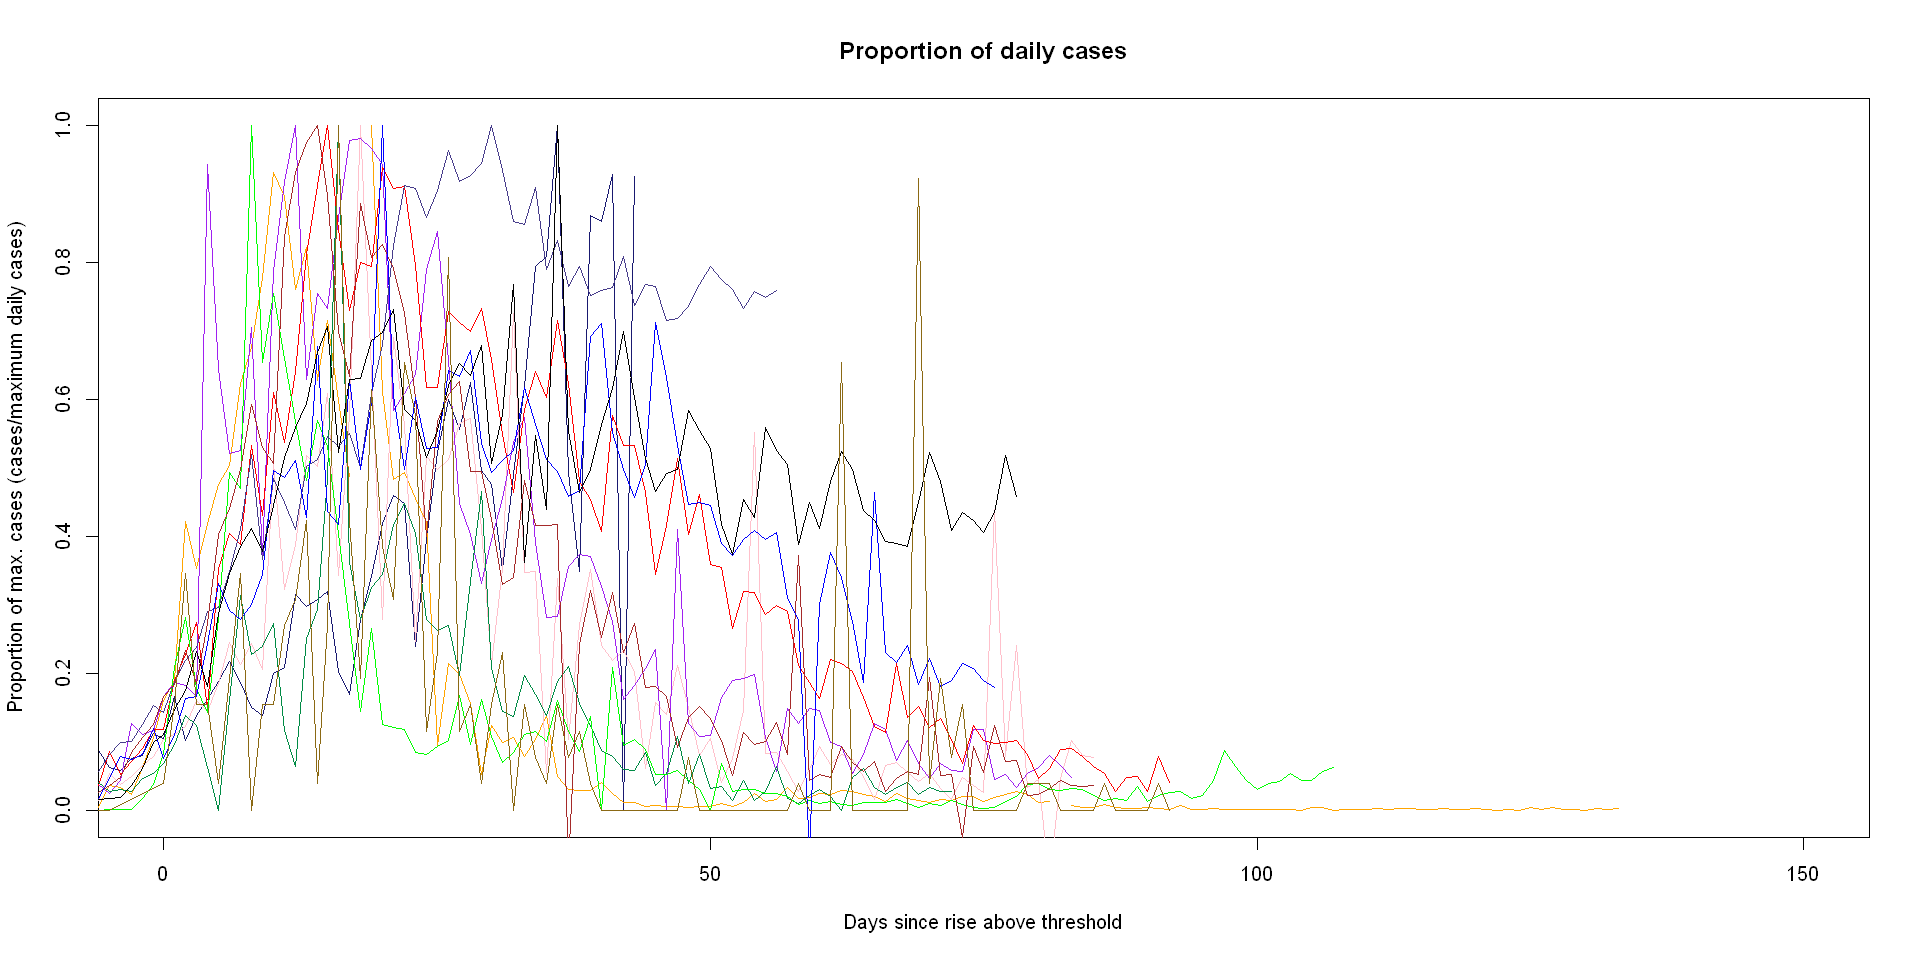

In [20]:
# A list of country names (which must match a name in the `countries` list).
selected_countries <- c('United_Kingdom', 'South_Korea', 'Italy', 'China',
                        'United_States_of_America', 'Germany', 'Spain',
                        'France', 'Russia', 'Japan', 'Vietnam', 'Brazil',
                        'Zambia')
# A list of colours which will be used in the same order as the countries above.
# If there are too many colours the excess are ignored. Too few 
selected_colors <- c('blue', 'green', 'red', 'orange', 'black', 'purple',
                     'brown', 'pink', 'slateblue4', 'springgreen4',
                     'goldenrod4', 'midnightblue')
# Now define the period of time after the start date (defined above as the date
# when the daily count reached n% of the maximum daily count for a country).
period <- 150
# Plot the number of daily cases.
# Set the display to plot 2 graphs side-by-side.
options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow=c(1,1))
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), cases/max_cases,
                  type='l', col=selected_colors[colour],
                  main='Proportion of daily cases',
                  xlab='Days since rise above threshold', 
                  ylab='Proportion of max. cases (cases/maximum daily cases)',
                  xlim=c(0, period), ylim=c(0, 1)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), cases/max_cases,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}

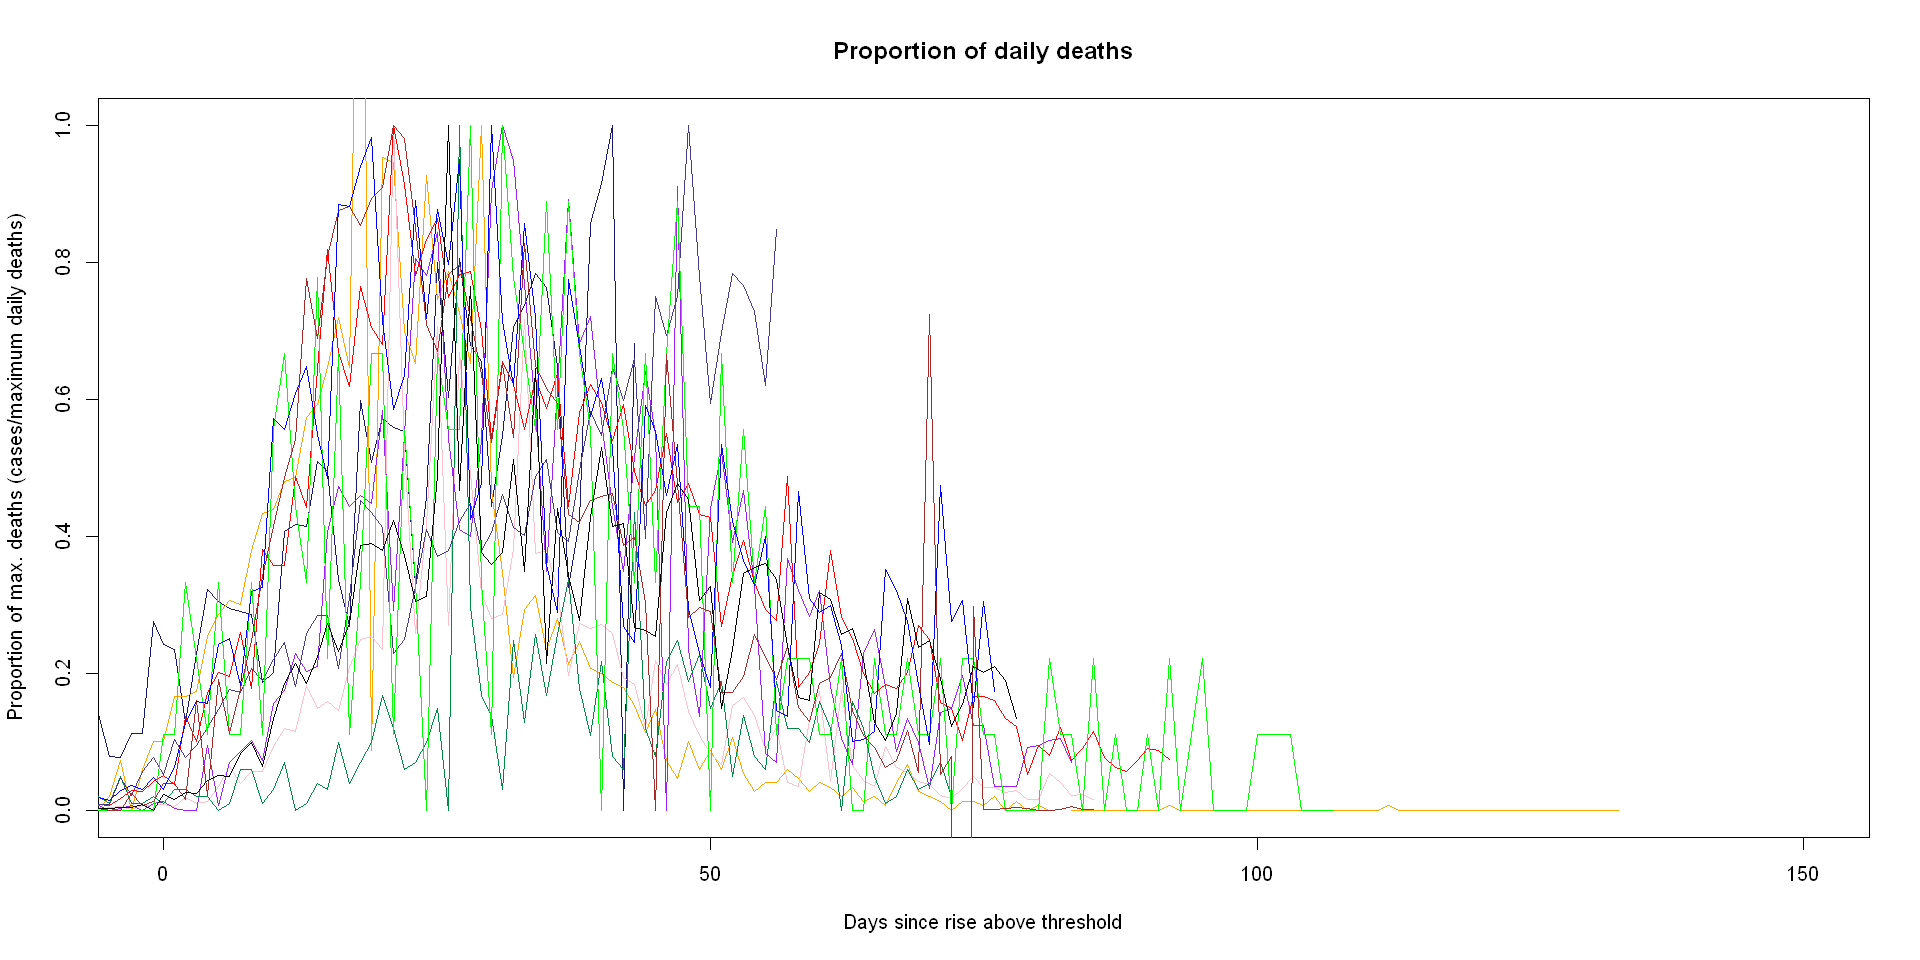

In [21]:
# Plot the number of daily deaths.
# Set the display to plot 2 graphs side-by-side.
options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow=c(1,1))
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), deaths/max_deaths,
                  type='l', col=selected_colors[colour],
                  main='Proportion of daily deaths',
                  xlab='Days since rise above threshold', 
                  ylab='Proportion of max. deaths (cases/maximum daily deaths)',
                  xlim=c(0, period), ylim=c(0, 1)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), deaths/max_deaths,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}

### Plot the _smoothed_ cases and death data for a selection of countries.

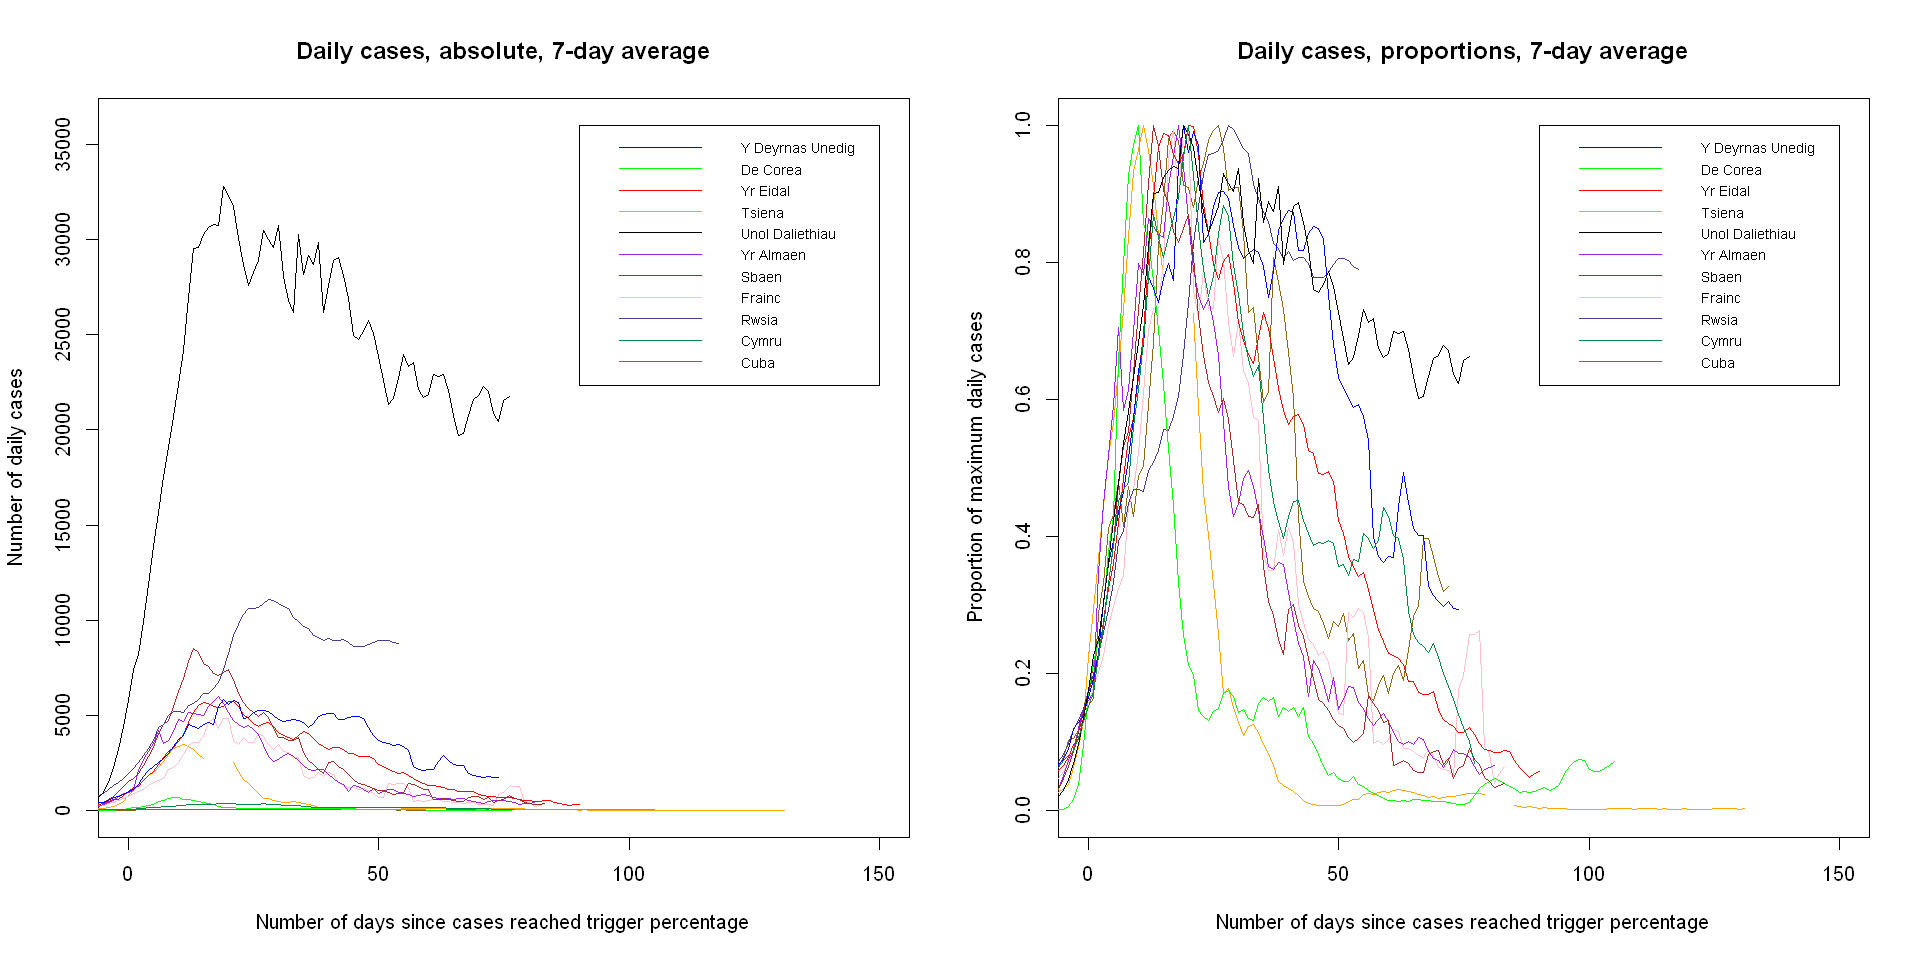

In [22]:
# A list of country names (which must match a name in the `countries` list).
selected_countries <- c('United_Kingdom', 'South_Korea', 'Italy', 'China',
                        'United_States_of_America', 'Germany', 'Spain',
                        'France', 'Russia', 'Wales', 'Cuba')
# A matching list of country names for the labels (which do not need to match
# the names in the `countries` list).
legend_countries <- c('Y Deyrnas Unedig', 'De Corea', 'Yr Eidal', 'Tsiena',
                      'Unol Daliethiau', 'Yr Almaen', 'Sbaen', 'Frainc',
                      'Rwsia', 'Cymru', 'Cuba')
# A list of colours which will be used in the same order as the countries above.
selected_colors <- c('blue', 'green', 'red', 'orange', 'black', 'purple',
                     'brown', 'pink', 'slateblue4', 'springgreen4',
                     'goldenrod4', 'midnightblue', 'scarlet')
period <- 150
ymax <- 36000
# Set the display to plot 2 graphs side-by-side.
options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow=c(1,2))
# Plot the 7-day-averaged number of daily cases (with absolute counts).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases,
                  type='l', col=selected_colors[colour],
                  xlim=c(0, period), ylim=c(0, ymax),
                  main='Daily cases, absolute, 7-day average',
                  xlab='Number of days since cases reached trigger percentage',
                  ylab='Number of daily cases'))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend(x=c(period*0.6, period), y=c(ymax*0.62, ymax), legend=legend_countries, col=selected_colors, lty=1, cex=0.7)
# Plot the 7-day-averaged number of daily cases (with counts scaled to each country's maximum).
ymax <- 1
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases,
                  type='l', col=selected_colors[colour],
                  xlim=c(0, period), ylim=c(0, 1),
                  main='Daily cases, proportions, 7-day average',
                  xlab='Number of days since cases reached trigger percentage',
                  ylab='Proportion of maximum daily cases'))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend(x=c(period*0.6, period), y=c(ymax*0.62, ymax), legend=legend_countries, col=selected_colors, lty=1, cex=0.7)

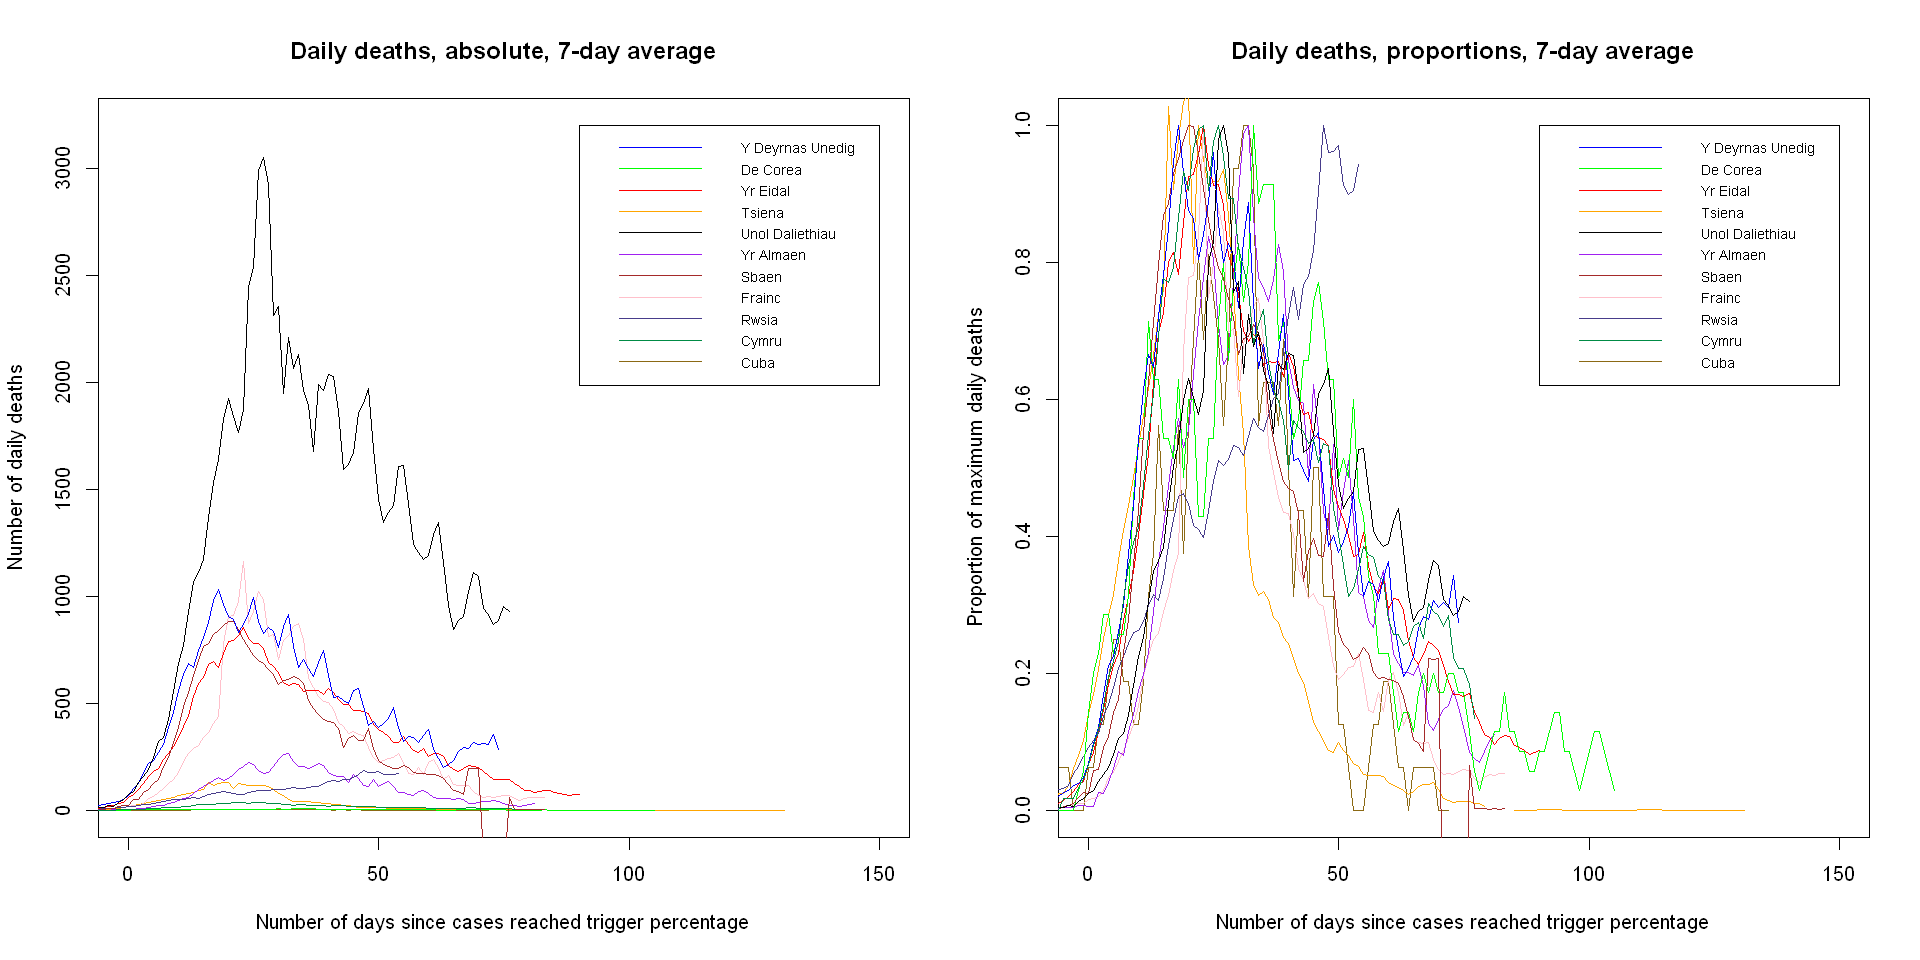

In [23]:
# Deaths (absolute first, then scaled wrt maximum).
period <- 150
ymax <- 3200
# Set the display to plot 2 graphs side-by-side.
options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow=c(1,2))
# Plot the 7-day-averaged number of daily deaths (with absolute counts).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), 
             plot(as.Date(dateRep) - as.Date(first_case), smoothed_deaths,
                  type='l', col=selected_colors[colour],
                  xlim=c(0, period), ylim=c(0, 3200),
                  main='Daily deaths, absolute, 7-day average',
                  xlab='Number of days since cases reached trigger percentage',
                  ylab='Number of daily deaths'))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), 
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend(x=c(period*0.6, period), y=c(ymax*0.62, ymax), legend=legend_countries, col=selected_colors, lty=1, cex=0.7)
# Plot the 7-day-averaged number of daily deaths (with counts scaled to each country's maximum).
ymax <- 1
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths,
                  type='l', col=selected_colors[colour],
                  xlim=c(0, period), ylim=c(0, 1),
                  main='Daily deaths, proportions, 7-day average',
                  xlab='Number of days since cases reached trigger percentage',
                  ylab='Proportion of maximum daily deaths'))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend(x=c(period*0.6, period), y=c(ymax*0.62, ymax), legend=legend_countries, col=selected_colors, lty=1, cex=0.7)

### Comparison of Scaled Cases and Deaths

Plotting the scaled cases and deaths on the same axes allows comparison of the time-series.

In [ ]:
selected_countries <- c('Germany', 'United_Kingdom', 'Wales') 
    #, 'France', 'Italy', 'Greece', 'South_Korea') #'United_Kingdom') 
    #, 'Germany', 'Italy', 'South_Korea', 'Russia', 'Brazil', 'Greece')
    #, 'South_Korea', 'Italy', 'China', 'United_States_of_America', 'Germany',
    #  'Spain', 'France', 'Russia', 'Japan', 'Vietnam', 'Brazil')
selected_colors <- c('blue', 'darkgreen', 'red', 'orange', 'purple', 'black',
                     'midnightblue', 'pink', 'slateblue4', 'springgreen4',
                     'goldenrod4', 'pink')
period <- 90
# Get y-scale
i <- 1
y_max <- 0
for (country in selected_countries) {
    max_country_cases <- (countries %>%
                          filter(countriesAndTerritories==country) %>%
                          select(max_smoothed_cases))[[1]]
    if (max_country_cases > y_max) {
        y_max <- max_country_cases
    }
}
cat('Maximum count =', y_max, sep=' ')
y_max <- 1
# Cases (scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>%
                  filter(countriesAndTerritories==country) %>%
                  select(max_smoothed_cases))[[1]]
    first_case <- (countries %>%
                   filter(countriesAndTerritories==country) %>%
                   select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases,
                  type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max),
                  main='Comparison of cases and deaths for selected countries',
                  xlab='Number of days since cases reached trigger percentage',
                  ylab='Proportion of maximum daily cases (solid lines) or deaths (dotted lines)'))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
# Deaths (scaled wrt maximum and on the same plot as the deaths).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>%
                   filter(countriesAndTerritories==country) %>%
                   select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>%
                   filter(countriesAndTerritories==country) %>%
                   select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths,
                   type='l', lty=3, col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths,
                   type='l', lty=3, col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=selected_countries, col=selected_colors, lty=1, cex=0.7)
# Add some horzontal/vertical markers.
lines(c(0,0), c(0,1), col='black', lty=3)
lines(c(-2,88), c(trigger_pc/100,trigger_pc/100), col='black', lty=4)
lines(c(-2,88), c(0,0), col='black', lty=3)

Maximum count = 5960.2

### Exploring Other Countries

A separate set of plots to investigate other countries which may be of interest.

In [ ]:
selected_countries <- c(#'Germany', 'South_Korea', 
                        'United_Kingdom', 'United_States_of_America', 'Russia', 'Brazil', 'Sweden')
    # 'United_Kingdom') #, 'Germany', 'Italy', 'South_Korea', 'Russia', 'Brazil', 'Greece')
    #, 'South_Korea', 'Italy', 'China', 'United_States_of_America', 'Germany',
    # 'Spain', 'France', 'Russia', 'Japan', 'Vietnam', 'Brazil')
selected_colors <- c(#'yellow', 'yellow',
                     'blue', 'darkgreen', 'red', 'orange', 'purple', 'black',
                     'midnightblue', 'pink', 'slateblue4', 'springgreen4',
                     'goldenrod4', 'pink')
period <- 90
# Get y-scale
i <- 1
y_max <- 0
for (country in selected_countries) {
    max_country_cases <- (countries %>%
                          filter(countriesAndTerritories==country) %>%
                          select(max_smoothed_cases))[[1]]
    if (max_country_cases > y_max) {
        y_max <- max_country_cases
    }
}
cat('Maximum count =', y_max, sep=' ')
y_max <- 1
# Cases (scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>%
                  filter(countriesAndTerritories==country) %>%
                  select(max_smoothed_cases))[[1]]
    first_case <- (countries %>%
                   filter(countriesAndTerritories==country) %>%
                   select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases,
                  type='l', col=selected_colors[colour],
                  xlim=c(0, period), ylim=c(0, y_max),
                  main='Comparison of cases and deaths for selected countries',
                  xlab='Number of days since cases reached trigger percentage',
                  ylab='Proportion of maximum daily cases (solid lines) or deaths (dotted lines)')
            )
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country),
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases,
                   type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
# Deaths (scaled wrt maximum and on the same plot as the deaths).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>%
                   filter(countriesAndTerritories==country) %>%
                   select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>%
                   filter(countriesAndTerritories==country) %>%
                   select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        # cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), 
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths,
                   type='l', lty=3, col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), 
             lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths,
                   type='l', lty=3, col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=selected_countries, col=selected_colors, lty=1, cex=0.7)
# Add some horzontal/vertical markers.
lines(c(0,0), c(0,1), col='black', lty=3)
lines(c(-2,88), c(trigger_pc/100,trigger_pc/100), col='black', lty=4)
lines(c(-2,88), c(0,0), col='black', lty=3)